# -1) Imports

In [1]:
import pandas as pd

from sklearn                  import datasets

from pyspark.sql              import Row
from pyspark.sql.types        import Row

from pyspark.ml               import Pipeline

from pyspark.ml.feature       import VectorAssembler

from pyspark.ml.clustering    import KMeans
from pyspark.ml.clustering    import KMeansModel

from pyspark.mllib.linalg     import Vectors
from pyspark.mllib.linalg     import SparseVector

from pyspark.mllib.regression import LabeledPoint

# 0) Spark 2.0 

In [2]:
spark = SparkSession\
        .builder\
        .appName("PythonKMeansExample")\
        .getOrCreate()

# 1) Imports de données : scikit learn-> pandas

In [3]:
#scikit-learn et pandas
iris          = datasets.load_iris()
data          = iris['data']
features      = iris['feature_names']
Y             = iris['target']
pd_df         = pd.DataFrame(data)
pd_df.columns = features

# 2) Pandas -> Spark

In [4]:
#spark_df est une matrice d'objet 'ROW'
spark_df      = spark.createDataFrame(pd_df)

# 3) Algo

In [5]:
# parametres
ignore           = []
inputCols        = [x for x in spark_df.columns if x not in ignore]
outputCol        = 'features'
FeaturesCol      = outputCol
predictionCol    = "prediction"
nb_k_clusters    = 3

# 3.1) Créer une colonne de vecteurs à partir des objets 'Row‘
# transformer
assembler        = VectorAssembler(inputCols = inputCols,
                                   outputCol = outputCol)
# 3.2) Créer un prédicteur s'appuyant sur le vecteur
# estimator
kmeans_estimator = KMeans(k=nb_k_clusters)
kmeans_estimator.setFeaturesCol(FeaturesCol)
kmeans_estimator.setPredictionCol(predictionCol)

KMeans_4c90a5024e18aab17bac

# 4) instanciation de l'algo

In [7]:
# 4.1) trasnformation (via le transformer)
transformed_df = assembler.transform(spark_df)
# 4.2) modelisation (via l'estimator)
kmeans_model   = kmeans_estimator.fit(transformed_df)
# 4.3) prediction (via le modèle - qui est aussi un transformer)
predicted_df   = kmeans_model.transform(transformed_df)


# 5) verification

In [8]:
transformed_df.take(1)

[Row(sepal length (cm)=5.1, sepal width (cm)=3.5, petal length (cm)=1.4, petal width (cm)=0.2, features=DenseVector([5.1, 3.5, 1.4, 0.2]))]

In [9]:
predicted_df.take(1)

[Row(sepal length (cm)=5.1, sepal width (cm)=3.5, petal length (cm)=1.4, petal width (cm)=0.2, features=DenseVector([5.1, 3.5, 1.4, 0.2]), prediction=1)]

# 6) Cleaning : suppression des colonnes condensées en vecteurs

In [20]:
for feature in features:
    predicted_df = predicted_df.drop(feature)
predicted_df.take(60)

# 7) organiser l'algorithme (step 4) dans un Pipeline

In [25]:
stages        = [assembler, kmeans_estimator]
pipeline      = Pipeline(stages=stages)

# 7.1) Fitter le pipeline / obetenir un modèle 

In [26]:
pipelineModel = pipeline.fit(spark_df)

# 7.2) Appliquer le pipeline sur la spark dataframe

In [27]:
pipelineModel.transform(spark_df).take(3)

[Row(sepal length (cm)=5.1, sepal width (cm)=3.5, petal length (cm)=1.4, petal width (cm)=0.2, features=DenseVector([5.1, 3.5, 1.4, 0.2]), prediction=1),
 Row(sepal length (cm)=4.9, sepal width (cm)=3.0, petal length (cm)=1.4, petal width (cm)=0.2, features=DenseVector([4.9, 3.0, 1.4, 0.2]), prediction=1),
 Row(sepal length (cm)=4.7, sepal width (cm)=3.2, petal length (cm)=1.3, petal width (cm)=0.2, features=DenseVector([4.7, 3.2, 1.3, 0.2]), prediction=1)]

# 8) PCA

In [28]:
from pyspark.ml.feature import PCA as PCAml

In [29]:
pca         = PCAml(k=2, inputCol="features", outputCol="pca")
model       = pca.fit(transformed_df)
transformed = model.transform(predicted_df)
transformed.take(2)

[Row(features=DenseVector([5.1, 3.5, 1.4, 0.2]), prediction=1, pca=DenseVector([-2.8271, -5.6413])),
 Row(features=DenseVector([4.9, 3.0, 1.4, 0.2]), prediction=1, pca=DenseVector([-2.796, -5.1452]))]

# 8.1) extraction X, Y

In [30]:
from pyspark.ml.feature       import VectorSlicer

In [31]:
x_splitter = VectorSlicer(inputCol = "pca", outputCol = "x", indices=[0])
y_splitter = VectorSlicer(inputCol = "pca", outputCol = "y", indices=[1])

In [32]:
x_added    = x_splitter.transform(transformed)
y_added    = y_splitter.transform(x_added)
y_added.take(2)

[Row(features=DenseVector([5.1, 3.5, 1.4, 0.2]), prediction=1, pca=DenseVector([-2.8271, -5.6413]), x=DenseVector([-2.8271]), y=DenseVector([-5.6413])),
 Row(features=DenseVector([4.9, 3.0, 1.4, 0.2]), prediction=1, pca=DenseVector([-2.796, -5.1452]), x=DenseVector([-2.796]), y=DenseVector([-5.1452]))]

# 8.2) spark -> pandas

In [33]:
pd_data    = y_added.toPandas()
pd_data[:2]

,features,prediction,pca,x,y
0,"[5.1, 3.5, 1.4, 0.2]",1,"[-2.82713597268, -5.64133104557]",[-2.82713597268],[-5.64133104557]
1,"[4.9, 3.0, 1.4, 0.2]",1,"[-2.79595248215, -5.14516688325]",[-2.79595248215],[-5.14516688325]


# 8.3) vecteur => float

In [34]:
pd_data["y"] = pd_data["y"].apply(lambda x: x[0])
pd_data["x"] = pd_data["x"].apply(lambda x: x[0])
pd_data[:2]

,features,prediction,pca,x,y
0,"[5.1, 3.5, 1.4, 0.2]",1,"[-2.82713597268, -5.64133104557]",-2.827136,-5.641331
1,"[4.9, 3.0, 1.4, 0.2]",1,"[-2.79595248215, -5.14516688325]",-2.795952,-5.145167


# 9) Datavisualisation

# 9.1) Matplotlib

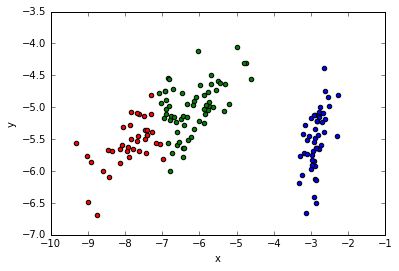

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
colors   = ['red', 'blue', 'green']
fig, ax  = plt.subplots(1,1)
for prediction in range(nb_k_clusters):
    pd_data[pd_data.prediction==prediction].plot(kind='scatter', x='x', y='y', color=colors[prediction], ax=ax)


# 9.2) Seaborn

In [36]:
import seaborn as sns

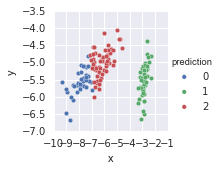

In [37]:
tips = sns.pairplot(pd_data, x_vars='x', y_vars='y', hue='prediction')

# 9.3) Bokeh

In [38]:
from bokeh.plotting import figure, show,  output_notebook
output_notebook() 
prediction0 = pd_data[pd_data["prediction"]==0]
prediction1 = pd_data[pd_data["prediction"]==1]
prediction2 = pd_data[pd_data["prediction"]==2]
colors      = ['red', 'blue', 'green']
marker      = ["square_cross", "diamond", "inverted_triangle"]
p = figure(title="predictions")
for i, data in enumerate([prediction0, prediction1, prediction2]):
    p.scatter(data["x"], data["y"], marker=marker[i], color=colors[i])
show(p)

Loading BokehJS ...

# 9.4) plotly

In [39]:
import plotly.plotly     as py
import plotly.graph_objs as go

In [40]:
import plotly
username = 'romainjouin'
api_key  = 'xi4kmky59i'
plotly.tools.set_credentials_file(username, api_key)
py.sign_in(username, api_key)

In [41]:
trace = go.Scatter(
    x         = pd_data['x'],
    y         = pd_data['y'],
    mode      = 'markers',
    marker = dict(color =  pd_data['prediction'])
)
py.iplot([trace], filename="output.html")


# 10) La classification est-elle bonne ? 

In [46]:
clusters = []
for k in range( nb_k_clusters):
    cluster = predicted_df.filter(predicted_df.prediction==k)
    clusters.append(cluster)
    print u"cluster {0} : {1} éléments".format(k,cluster.count())


cluster 0 : 38 éléments
cluster 1 : 50 éléments
cluster 2 : 62 éléments


In [50]:
print u"nb d'éléments par cluster à l'origine :"
pd.Series(Y).value_counts()

nb d'éléments par cluster à l'origine :


2    50
1    50
0    50
dtype: int64

In [123]:
predictions  = predicted_df.toPandas()
Y_reel       = pd.DataFrame(Y, columns=['Y'])
versus       = pd.concat([predictions,  Y_reel], axis=1)

In [130]:
erreur_total = 0
nb_erronnes  = 0
couts        = {0:5, 1:10, 2:15}
for vrai_cluster in versus.Y.unique():
    vrai_fleurs   = versus[versus.Y == vrai_cluster]
    oracle        = vrai_fleurs.prediction.value_counts()
    nb_d_erreur   = oracle.min() if oracle.min()<50 else 0
    pct_erreur    = nb_d_erreur / float(50)
    erreur_total +=nb_d_erreur
    nb_erronnes  += sum([nb_d_erreur>0])
    cout          = nb_d_erreur * couts[vrai_cluster]
    
    print "-"*10
    print "cluster ", vrai_cluster
    print "nb de prédictions par valeur :"
    print "%s"%oracle
    print "nb_d_erreur intra-cluster : %s"%nb_d_erreur
    print "pct_erreur intra-cluster : %s"%pct_erreur
print "="*10
print "Nb erreur totales  :", erreur_total
print "Pct total d'erreur :", erreur_total/float(150)
print "Nb de cluster erronnés :", nb_erronnes
print "Cout de l'algorithme : ", cout


----------
cluster  0
nb de prédictions par valeur :
1    50
Name: prediction, dtype: int64
nb_d_erreur intra-cluster : 0
pct_erreur intra-cluster : 0.0
----------
cluster  1
nb de prédictions par valeur :
2    48
0     2
Name: prediction, dtype: int64
nb_d_erreur intra-cluster : 2
pct_erreur intra-cluster : 0.04
----------
cluster  2
nb de prédictions par valeur :
0    36
2    14
Name: prediction, dtype: int64
nb_d_erreur intra-cluster : 14
pct_erreur intra-cluster : 0.28
Nb erreur totales  : 16
Pct total d'erreur : 0.106666666667
Nb de cluster erronnés : 2
Cout de l'algorithme :  210
